In [ ]:
import os
import random
import numpy as np
import torch
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# utility functions
from utils import *

# Models
from models.chromosome_model import create_ga_chromosome_metrics
from models.cnn_model import *
from models.lstm_model import *
from models.transformer_model import *
from models.mlp_model import *

# Scripts
from scripts.train_ga import *
from scripts.train_mlp import *
from scripts.train_cnn import *
from scripts.train_lstm import *
from scripts.train_transformer import *
from scripts.ensemble import *

# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set environment seed (optional)
os.environ['PYTHONHASHSEED'] = str(seed)



# Ensemble Trading Strategy Pipeline

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Genetic Algorithm Best Chromosome](#Genetic-Algorithm-Best-Chromosome)
4. [Model Loading and Predictions](#Model-Loading-and-Predictions)
   - 4.1 [MLP Model](#MLP-Model)
   - 4.2 [CNN Model](#CNN-Model)
   - 4.3 [LSTM Model](#LSTM-Model)
   - 4.4 [Transformer Model](#Transformer-Model)
5. [Ensemble Voting Strategies and Evaluation Metrics](#Ensemble-Voting-Strategies-and-Evaluation-Metrics)
   - 5.1 [Ensemble Methods Evaluated](#Ensemble-Methods)
   - 5.2 [Evaluation Metrics](#Evaluation-Metrics)
6. [BConclusion](#Conclusion)
   - 6.1 [Ensemble Model Performance](#Ensemble-Model-Performance)
   - 6.2 [Extensions and Future Work](#Extensions-and-Future-Work)
7. [Visualization](#Visualization)
   - 7.1 [Equity Curve](#Equity-Curve)
   - 7.2 [Prediction Signals](#Prediction-Signals)
   - 7.3 [Confusion Matrix](#Confusion-Matrix)
8. [Conclusions and Next Steps](#Conclusions-and-Next-Steps)

---



## **Introduction**

This pipeline serves as a foundation for production-grade quantitative trading strategies, combining modern data science methods with robust financial evaluation to inform practical trading decisions. This notebook presents a the comprehensive ensemble-based quantitative trading pipeline integrating the following elements:

- *Genetic Algorithm optimization* for technical indicator parameters
- *Machine learning architectures* including MLP, CNN, LSTM, and Transformer models
- *Ensemble prediction frameworks* using both majority and probabilistic voting methods
- *Advanced backtesting and evaluation metrics* for rigorous strategy assessment

### **Objective**

The primary goal is to develop a robust trading system that combines optimized technical indicators and diverse predictive models to enhance. By leveraging multiple models with distinct feature representations and learning capacities, the ensemble approach mitigates the overfitting risks inherent in single-model strategies thereby improving:

- *Prediction accuracy*
- *Risk-adjusted returns*
- *Robustness across market regimes*

**Technical Signal Optimization**  
- Genetic Algorithm tuning for RSI thresholds and intervals, improving signal informativeness.

**Model Diversity and Tuning**  
- Implementation of MLP, CNN, LSTM, and Transformer architectures, each hyperparameter-tuned for optimal performance on historical data.

**Ensemble Integration**  
- Weighted majority voting and probabilistic averaging for aggregated predictive robustness.

**Advanced Backtesting and Evaluation**  
- Comprehensive trading performance metrics:
  - Sharpe Ratio
  - Sortino Ratio
  - Calmar Ratio
  - Omega Ratio
  - Gain to Pain Ratio
  - Win Rate
  - Profit Factor
- Evaluation under static, dynamic, and Kelly criterion-based position sizing.

---

## Data Preparation

In this section, we load historical financial data for the selected ticker, apply technical indicators, and prepare the dataset for model input.

#### Steps:

1. Download historical price data using the Yahoo Finance API wrapper.
2. Calculate technical indicators:
   - Relative Strength Index (RSI) over multiple intervals
   - Simple Moving Averages (SMA) for trend identification
3. Define trend labels based on SMA crossovers to classify uptrends and downtrends.

The prepared dataset will be used for generating features and labels required by each machine learning model in the pipeline. Here it is possible to change the ticker to another of your choosing, in this notebook we will be using the Tesla stock ticker.

Other examples could be:
- ticker = "BTC-USD"  # Bitcoin
- ticker = "GLD"  # SPDR Gold Shares
- ticker = "XLF"  # Financial sector ETF
- ticker = "TSLA"  # Tesla, for a high-volatility equity


In [2]:
ticker = "TSLA"
start_date = "1997-01-01"
end_date = "2017-01-01"
df = download_stock_data(ticker, start_date, end_date)
df = add_technical_indicators(df, ticker)

[*********************100%***********************]  1 of 1 completed

Data saved: TSLA_technical_indicators.csv


## Genetic Algorithm Best Chromosome

In this section, we load the optimized RSI and interval parameters generated by the Genetic Algorithm (GA) tuning process.

### Purpose

The GA searches for the combination of RSI thresholds and interval lengths that maximize a predefined *fitness function* related to trading performance. These optimized parameters are critical for generating features and labels for model training and evaluation.

### Optimization Problem

The GA seeks to maximize the *fitness function* defined as:

$$
\text{Fitness} = \frac{R_a}{|\text{Max Drawdown}|}
$$

where:

- $ R_a $ is the *annualized return*, calculated as:

$$
R_a = \left( \frac{P_{end}}{P_{start}} \right)^{\frac{252}{N}} - 1
$$

Here:
  - $ P_{end} $ = portfolio value at end
  - $ P_{start} $ = portfolio value at start
  - $ N $ = number of trading days

- *Max Drawdown* is the largest observed loss from a peak to a trough before a new peak is reached, calculated as:

$$
\text{Max Drawdown} = \min_t \left( \frac{P_t - \max_{i \leq t} P_i}{\max_{i \leq t} P_i} \right)
$$

---

### Chromosome Representation

Each *chromosome* in the GA population encodes a set of RSI-based trading parameters:

- Downtrend buy value and interval
- Downtrend sell value and interval
- Uptrend buy value and interval
- Uptrend sell value and interval

### Steps

1. *Load GA results* from the saved CSV file containing the final tuned chromosomes.
2. *Extract the best chromosome* based on the highest fitness score.
3. *Prepare these optimized parameters* for feature generation and labeling in the machine learning pipeline.

These parameters ensure that models are trained using historically optimal RSI thresholds and intervals, enhancing trading signal relevance.


In [ ]:
create_ga_chromosome_metrics(ticker)

### Genetic Algorithm Chromosome Performance Interpretation

The table below summarizes the performance of multiple chromosomes, each representing a set of RSI thresholds and intervals optimized by the Genetic Algorithm (GA).

<div align="center">

| **Metric** | **Explanation** |
|------------|-----------------|
| down_buy_val / down_buy_int | RSI buy threshold and interval during downtrend |
| down_sell_val / down_sell_int | RSI sell threshold and interval during downtrend |
| up_buy_val / up_buy_int | RSI buy threshold and interval during uptrend |
| up_sell_val / up_sell_int | RSI sell threshold and interval during uptrend |
| total_return | Overall return factor (e.g. 1.12 = +12%) |
| annualized_return | Annualized return scaled to a yearly basis |
| sharpe_ratio | Risk-adjusted return accounting for standard deviation |
| sortino_ratio | Risk-adjusted return penalizing only downside volatility |
| max_drawdown | Largest peak-to-trough decline observed |
| fitness | Defined as annualized return divided by absolute max drawdown |

</div>

Here we observe that:

- Highest fitness:  
  - Chromosome index 4 with fitness = 0.8909, annualized return = 14.5%, and very low max drawdown = –16.3%.  
  - This represents the best risk-adjusted performance under the defined fitness metric.

- Highest total return:  
  - Chromosome index 2 with total return = 3.38x (238% net gain), annualized return = 25.5%, and max drawdown = –40.6%.  
  - While it achieves the highest returns, the drawdown is significantly higher, reducing its fitness relative to index 4.

The optimal chromosome selection depends on trading objectives:

- *Return maximization focus:  
  - Chromosome index 2 is preferable if the objective is to maximize absolute returns, accepting higher drawdown volatility.

- Risk-adjusted optimization focus:  
  - Chromosome index 4 is optimal when prioritizing stable growth with controlled drawdown exposure.


These optimized parameters will guide feature generation and labeling for all subsequent machine learning models in the pipeline. We will be moving forward with the 


### Alternative Fitness Functions for Genetic Algorithm Optimization

Below are alternative fitness functions that have been implemented in this code that be used to optimize trading strategy performance, each with its mathematical definition and interpretation. 
Selecting a fitness function depends on your *trading objectives* (max return, max risk-adjusted return, drawdown minimization) and your *risk tolerance* for the strategy. Consider testing multiple objectives to identify which yields the most robust out-of-sample performance.

---

**Sharpe Ratio**

Measures *risk-adjusted return*, penalizing both upside and downside volatility.

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

- $ R_p $: portfolio return  
- $ R_f $: risk-free rate  
- $ \sigma_p $: standard deviation of portfolio returns

**Sortino Ratio**

Adjusts for *downside risk only*, ignoring upside volatility.

$$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_D}
$$

- $ \sigma_D $: standard deviation of negative returns (downside deviation)


In [ ]:
genetic_algorithm(ticker, override_selection_metric='sharpe_ratio')

## Model Loading and Predictions

In this section, we load each trained machine learning model and generate their predictions on the prepared labeled dataset.

### Purpose

The ensemble pipeline integrates predictions from multiple models to enhance trading signal robustness. Each model was trained using the optimized technical indicator parameters obtained from the Genetic Algorithm and tuned for hyperparameter configurations.

**Models included**:

1. *MLP (Multi-Layer Perceptron)*
2. *CNN (Convolutional Neural Network)*
3. *LSTM (Long Short-Term Memory Network)*
4. *Transformer Model*

**Steps**:

1. *Load trained model weights* from saved `.pth` files.
2. *Prepare model input data* with correct feature structure.
3. *Generate predictions* using each model in evaluation mode.
4. *Store predictions for ensemble integration.*

The outputs from this section will be used to construct ensemble voting strategies in subsequent analyses.

---

### MLP Model

In this subsection, we load the trained Multi-Layer Perceptron (MLP) model and generate its predictions on the prepared labeled dataset.

#### Model overview

The *MLP model* is a fully connected feedforward neural network trained to classify trading actions (Buy, Sell, Hold) based on RSI features and trend information.

#### Mathematical formulation

An MLP with $ L $ layers can be formulated as:


\begin{aligned}
& h^{(0)} = x \\
& h^{(l)} = \sigma(W^{(l)} h^{(l-1)} + b^{(l)}), \quad l = 1, \ldots, L-1 \\
& \hat{y} = \text{softmax}(W^{(L)} h^{(L-1)} + b^{(L)})
\end{aligned}


where:

- $ x $ is the input feature vector (e.g. RSI value, interval, trend).  
- $ W^{(l)} $ and $ b^{(l)} $ are the weights and biases of layer $ l $.  
- $ \sigma $ is the activation function (e.g. ReLU).  
- softmax output yields class probabilities for Buy, Sell, Hold.

---

#### Steps:

1. Load model architecture with the tuned hidden layer configuration.
2. Load trained weights from the saved `.pth` file.
3. Prepare input tensor with required feature columns.
4. Generate predictions and extract class labels for ensemble integration.


In [ ]:
run_tuning_mlp(ticker)
best_mlp(ticker)

### CNN Model

In this subsection, we load the trained Convolutional Neural Network (CNN) model and generate its predictions on the prepared labeled dataset.

#### Model overview

The CNN model captures local temporal patterns in RSI and trend features by applying convolutional filters over input sequences, learning hierarchical representations relevant for trading signal classification.

#### Mathematical formulation

For a 1D CNN layer:

$$
h^{(l)}_i = \sigma \left( \sum_{k=0}^{K-1} W_k^{(l)} x_{i+k} + b^{(l)} \right)
$$

where:

- $ x $ is the input sequence.  
- $ W_k^{(l)} $ are the convolutional kernel weights of size $ K $.  
- $ b^{(l)} $ is the bias term.  
- $ \sigma $ is the activation function (e.g. ReLU).  
- $ h^{(l)}_i $ is the output feature map at position $ i $ in layer $ l $.

The final output is passed through fully connected layers and a softmax function to produce class probabilities for Buy, Sell, Hold.

---

#### Steps:

1. Load model architecture with tuned kernel size and hidden channels.  
2. Load trained weights from the saved `.pth` file.  
3. Prepare input tensors as rolling window sequences.  
4. Generate predictions and extract class labels for ensemble integration.


In [ ]:
tune_cnn_hyperparameters(ticker)
best_cnn(ticker)

### LSTM Model

In this subsection, we load the trained Long Short-Term Memory (LSTM) model and generate its predictions on the prepared labeled dataset.

#### Model overview

The LSTM model is a recurrent neural network architecture designed to capture sequential dependencies and temporal patterns in time series data, addressing the vanishing gradient problem present in traditional RNNs.

#### Mathematical formulation

An LSTM cell operates with the following equations at each time step $ t $:

\begin{aligned}
& f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f) \\
& i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i) \\
& o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o) \\
& \tilde{c}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c) \\
& c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
& h_t = o_t \odot \tanh(c_t)
\end{aligned}

where:

- $ x_t $ is the input vector at time $ t $.  
- $ h_{t-1} $ is the previous hidden state.  
- $ c_t $ is the cell state.  
- $ f_t, i_t, o_t $ are the forget, input, and output gates, respectively.  
- $ \tilde{c}_t $ is the candidate cell state.  
- $ W $ and $ U $ are weight matrices, $ b $ are biases.  
- $ \sigma $ denotes the sigmoid activation function, and $ \odot $ denotes element-wise multiplication.

---

#### Steps:

1. Load model architecture with tuned hidden size and number of layers.  
2. Load trained weights from the saved `.pth` file.  
3. Prepare input tensors as sequential rolling windows.  
4. Generate predictions and extract class labels for ensemble integration.


In [ ]:
tune_lstm_hyperparameters(ticker)
best_lstm(ticker)

### Transformer Model

In this subsection, we load the trained Transformer model and generate its predictions on the prepared labeled dataset.

#### Model overview

The Transformer model uses self-attention mechanisms to capture dependencies across the entire input sequence, enabling parallel computation and effective long-range pattern recognition in time series data.

#### Mathematical formulation

The Scaled Dot-Product Attention mechanism in the Transformer is defined as:

$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V
$$

where:

- $ Q $ = Query matrix  
- $ K $ = Key matrix  
- $ V $ = Value matrix  
- $ d_k $ = dimension of the key vectors

The Multi-Head Attention combines multiple attention heads:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W^O
$$

where each head is computed as:

$$
\text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V)
$$

---

#### Steps:

1. Load model architecture with tuned dimensions, number of heads, and layers.  
2. Load trained weights from the saved `.pth` file.  
3. Prepare input tensors as sequential feature windows.  
4. Generate predictions and extract class labels for ensemble integration.


In [ ]:
tune_transformer(ticker)
best_transformer(ticker)

### Ensemble Voting Strategies and Evaluation Metrics

In this section, we compare the performance of different *ensemble strategies* tested on our true out-of-sample dataset. Here, I am defining true out-of-sample dataset as the period of time from 2017-01-01 until today. This implies that the model has had 20 years to train on, however the model will be tested on only 8.5 years.

Furthermore, rather than relying upon one model alone, focus exclusively on ensemble approaches that combine the predictive power of MLP, CNN, LSTM, and Transformer models. Therefore we will not be evaluating each model individually in this notebook. The ensemble approach is as follows:

#### Ensemble Methods

1. Weighted Majority Voting Ensemble

   Combines model predictions using fixed assigned weights to each model’s vote.

   Formula:

   $$
   \text{Final Decision} = \arg \max_{c} \sum_{m=1}^{M} w_m \cdot \mathbb{1}_{\{p_m = c\}}
   $$

   where:
   - $ w_m $ is the weight of model $ m $
   - $ p_m $ is its predicted class
   - $ \mathbb{1}_{\{p_m = c\}} $ is an indicator if model $ m $ predicts class $ c $.

2. Probabilistic Voting Ensemble (Unconstrained)

   Averages the softmax probabilities across all models to derive the final prediction.

   Formula:

   $$
   \text{Final Decision} = \arg \max_{c} \left( \frac{1}{M} \sum_{m=1}^{M} P_m(c) \right)
   $$

   where $ P_m(c) $ is the predicted probability for class $ c $ from model $ m $.

3. Probabilistic Voting Ensemble (Constrained)

   Same as above, but executed with trading constraints such as:

   - Maximum position size
   - Stop-loss thresholds
   - Take-profit thresholds

   This reflects more realistic portfolio constraints.

4. Probabilistic Voting Ensemble with Kelly Criterion Sizing

   Uses averaged probabilistic predictions for signals, and dynamically sizes each trade based on the Kelly criterion calculated from historical win/loss ratios.

   Formula:

   $$
   f^* = \frac{bp - q}{b}
   $$

   where:
   - $ f^* $: optimal fraction of capital to bet
   - $ b $: odds received (average win / average loss)
   - $ p $: probability of winning
   - $ q = 1 - p $.
Ensemble Methods Evaluated
#### Evaluation Metrics

For each ensemble method, we report:

- Total Return
- Annualized Return
- Sharpe Ratio
- Sortino Ratio
- Maximum Drawdown
- Win Rate
- Profit Factor

Above some of these Evaluation Metrics have been defined below are the rest:

#### Calmar Ratio

Compares *annualized return to maximum drawdown* to assess return-risk tradeoff.

$$
\text{Calmar Ratio} = \frac{R_a}{|\text{Max Drawdown}|}
$$

- $ R_a $: annualized return

#### Omega Ratio

Considers the *entire distribution of returns relative to a target threshold*.

$$
\text{Omega Ratio} = \frac{\int_{r_T}^{\infty} [1 - F(r)] \, dr}{\int_{-\infty}^{r_T} F(r) \, dr}
$$

- $ r_T $: target return (e.g. 0)  
- $ F(r) $: cumulative distribution function of returns


#### Gain to Pain Ratio

Measures *total net gains relative to total absolute losses*.

$$
\text{Gain to Pain} = \frac{\sum \text{Returns}}{\sum |\text{Losses}|}
$$


#### Profit Factor

Calculates *gross profit divided by gross loss*.

$$
\text{Profit Factor} = \frac{\text{Gross Profit}}{|\text{Gross Loss}|}
$$


#### Expectancy per Trade

Indicates *average expected profit per trade* accounting for win/loss probabilities.

$$
\text{Expectancy} = (\text{Win Rate} \times \text{Avg Win}) - (\text{Loss Rate} \times \text{Avg Loss})
$$


#### CAGR to Max Drawdown Ratio

Compares *compound annual growth rate to maximum drawdown*.

$$
\text{CAGR/MDD} = \frac{\text{CAGR}}{|\text{Max Drawdown}|}
$$

- *CAGR* is calculated as:

$$
\text{CAGR} = \left( \frac{P_{end}}{P_{start}} \right)^{\frac{1}{n}} - 1
$$

where:
  - $ P_{end} $: ending portfolio value  
  - $ P_{start} $: starting portfolio value  
  - $ n $: number of years

In [4]:
%%capture
results_weighted_majority, portfolio_weighted_majority, trade_returns_weighted_majority, ensemble_predictions_weighted_majority, df_eval_weighted_majority = run_ensemble_backtest(ticker)
results_kelly, portfolio_kelly, trade_returns_kelly, ensemble_predictions_kelly, df_eval_kelly = run_probabilistic_ensemble_backtest_with_kelly(ticker)
results_prob_voting_uncon, portfolio_prob_voting_uncon, trade_returns_prob_voting_uncon, ensemble_predictions_prob_voting_uncon, df_eval_prob_voting_uncon = run_probabilistic_ensemble_backtest(ticker, position_size=1, stop_loss=1, take_profit=1)
results_prob_voting_con_min_pos, portfolio_prob_voting_con_min_pos, trade_returns_prob_voting_con_min_pos, ensemble_predictions_prob_voting_con_min_pos, df_eval_prob_voting_con_min_pos = run_probabilistic_ensemble_backtest(ticker, position_size=1)
results_prob_voting_tot_con, portfolio_prob_voting_tot_con, trade_returns_prob_voting_tot_con, ensemble_predictions_prob_voting_tot_con, df_eval_prob_voting_tot_con = run_probabilistic_ensemble_backtest(ticker)

In [5]:
metrics_weighted_majority = calculate_additional_metrics(portfolio_weighted_majority, trade_returns_weighted_majority)
metrics_kelly = calculate_additional_metrics(portfolio_kelly, trade_returns_kelly)
metrics_prob_voting_uncon = calculate_additional_metrics(portfolio_prob_voting_uncon, trade_returns_prob_voting_uncon)
metrics_prob_voting_con_min_pos = calculate_additional_metrics(portfolio_prob_voting_con_min_pos, trade_returns_prob_voting_con_min_pos)
metrics_prob_voting_tot_con = calculate_additional_metrics(portfolio_prob_voting_tot_con, trade_returns_prob_voting_tot_con)

combined_metrics_weighted_majority = {**results_weighted_majority, **metrics_weighted_majority}
combined_metrics_kelly = {**results_kelly, **metrics_kelly}
combined_metrics_prob_voting_uncon = {**results_prob_voting_uncon, **metrics_prob_voting_uncon}
combined_metrics_prob_voting_con_min_pos = {**results_prob_voting_con_min_pos, **metrics_prob_voting_con_min_pos}
combined_metrics_prob_voting_tot_con = {**results_prob_voting_tot_con, **metrics_prob_voting_tot_con}

table = ensemble_comparison_summary(combined_metrics_weighted_majority, combined_metrics_kelly, combined_metrics_prob_voting_uncon, combined_metrics_prob_voting_con_min_pos, combined_metrics_prob_voting_tot_con)


=== Ensemble Model Comparison Summary ===
                            Ensemble Method  Total Return  Annualized Return  Sharpe Ratio  Sortino Ratio  Max Drawdown  Win Rate  Profit Factor
                   Weighted Majority Voting        2.5765             0.1659        0.5823         0.4820       -0.5828    0.6867         1.7498
       Probabilistic Voting (Unconstrained)        1.1019             0.0936        0.4226         0.3604       -0.5484    0.6625         1.4621
Probabilistic Voting (Constrained, Min Pos)        0.6302             0.0606        0.3472         0.2851       -0.5484    0.4493         1.1799
 Probabilistic Voting (Totally Constrained)        0.2870             0.0309        0.3500         0.2881       -0.1682    0.4493         1.1799
        Probabilistic Voting + Kelly Sizing       -0.0225            -0.0027       -0.3128        -0.0287       -0.0348    0.3333         0.2599


### Conclusion 
#### Ensemble Model Performance

This analysis compared multiple ensemble trading strategies across weighted majority voting, probabilistic voting (with and without constraints), and Kelly position sizing.

The Weighted Majority Voting ensemble achieved the highest total return (+258%) with a strong profit factor (1.75). However, it suffered from an extremely large maximum drawdown of –58%, indicating significant volatility and potential risk of ruin in real-world deployment.

The Probabilistic Voting (Unconstrained) method delivered a solid return (+110%) and good win rate (66%) but maintained drawdowns above –54%, limiting its attractiveness from a risk management perspective.

Introducing constraints in probabilistic voting (minimum position sizing and total constraints) progressively reduced returns, with the Totally Constrained variant producing the lowest drawdown (–17%) but also a low annualized return (3.1%). This strategy prioritizes capital preservation over growth.

The Kelly Sizing strategy, while theoretically optimal under perfect assumptions, resulted in a slight overall loss (–2.3%) with very low drawdown. This suggests that the inputs for Kelly (estimated win rate and win/loss ratio) were insufficiently calibrated, leading to underbetting or risk-averse position sizes.

#### Summary of Tests
- Highest return: Weighted Majority Voting (+258%) but with high risk.
- Best risk control: Probabilistic Voting (Totally Constrained) with lowest drawdown (–17%) and modest returns.
- Kelly sizing underperformed, highlighting the importance of accurate statistical inputs for optimal bet sizing.


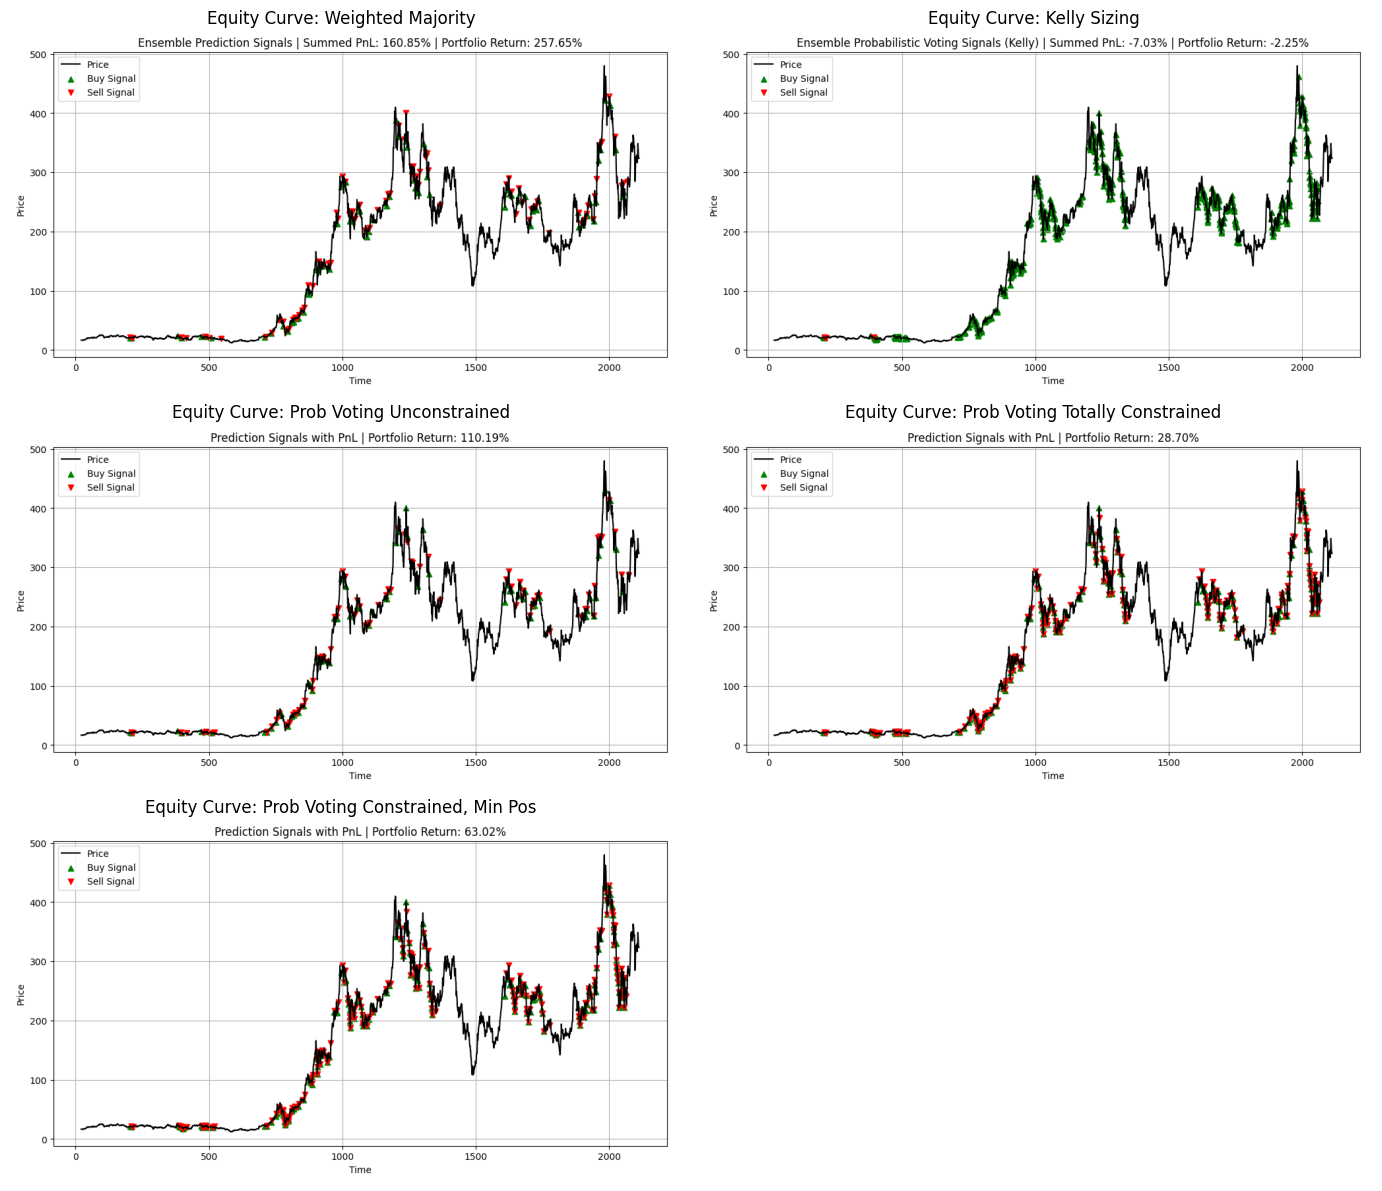

In [ ]:
weighted = mpimg.imread('plots/ensemble_weighted_voting_prediction_signals.png')
unconstrained = mpimg.imread('plots/ensemble_probabilistic_voting_signals_positionsize_1_sl_1.png')
totally_constrained = mpimg.imread('plots/ensemble_probabilistic_voting_signals_positionsize_0.25_sl_0.03.png')
kelly = mpimg.imread('plots/ensemble_probabilistic_voting_signals_kelly.png')
constrained_min_pos = mpimg.imread('plots/ensemble_probabilistic_voting_signals_positionsize_1_sl_0.03.png')

fig, axs = plt.subplots(3, 2, figsize=(14, 12))

axs[0, 0].imshow(weighted)
axs[0, 0].set_title('Equity Curve: Weighted Majority')
axs[0, 0].axis('off')

axs[0, 1].imshow(kelly)
axs[0, 1].set_title('Equity Curve: Kelly Sizing')
axs[0, 1].axis('off')

axs[1, 0].imshow(unconstrained)
axs[1, 0].set_title('Equity Curve: Prob Voting Unconstrained')
axs[1, 0].axis('off')

axs[1, 1].imshow(totally_constrained)
axs[1, 1].set_title('Equity Curve: Prob Voting Totally Constrained')
axs[1, 1].axis('off')

axs[2, 0].imshow(constrained_min_pos)
axs[2, 0].set_title('Equity Curve: Prob Voting Constrained, Min Pos')
axs[2, 0].axis('off')

# Optionally, hide the unused subplot (bottom right)
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


#### Extensions and Future Work

This research pipeline lays the foundation for deploying robust, interpretable, and extensible data-driven trading systems. The outlined extensions will transform this framework from an academic backtesting engine into a deployable production-grade quantitative strategy with adaptive risk control, capital allocation, and multi-model integration capabilities. However, while this study has built a robust ensemble-based trading framework with multiple backtested evaluation pipelines, several extensions remain to enhance both predictive accuracy and practical deployment:

1. Model Enhancements
   - Hyperparameter Optimization: Integrate Bayesian or evolutionary optimization (e.g. Optuna) for systematic tuning of CNN, LSTM, and Transformer architectures.
   - Advanced Architectures: Extend to Temporal Fusion Transformers, Attention-based CNN-LSTM hybrids, or modern Normalizing Flows for direct conditional return distribution modeling.

2. Feature Expansion
   - Incorporate macroeconomic indicators (e.g. FRED datasets) as exogenous features to improve regime awareness.
   - Engineer volatility, momentum, and liquidity features beyond RSI and SMA baselines.

3. Regime Switching Models
   - Combine Hidden Markov Models or unsupervised clustering with ensemble predictions to adapt strategy parameters dynamically based on market conditions.

4. Portfolio Context
   - Extend the single-asset framework to multi-asset portfolios, including optimal capital allocation across instruments based on expected risk-adjusted returns.

5. Risk Management Strategies
   - Implement advanced techniques such as dynamic position sizing with volatility scaling, tail risk hedging, and drawdown-based exposure throttling.
   - Explore Kelly fraction calibration, Bayesian Kelly approaches, and fractional Kelly to mitigate estimation uncertainty.

6. Execution and Slippage Modeling
   - Integrate realistic transaction cost models, slippage assumptions, and market impact constraints to simulate execution more accurately.

7. Online Learning and Live Deployment
   - Develop pipelines for rolling-window online retraining to adapt to changing market dynamics.
   - Prepare code for integration with broker APIs (e.g. Interactive Brokers) for live trading and real-time monitoring dashboards.
